# Title: Graph Classification and Regression
### Purpose: Given a network model, can we predict the values of specific security metrics through classification or regression? 
### Author: @mjz



## Global imports and notebook setup here

In [1]:
%matplotlib inline

#------ python libs ----------
import logging
import os
SEP = os.path.sep
import sys
import uuid
import pathlib

#------ notebook libs ----------
import matplotlib.pyplot as plt
import networkx as nx
import graphviz
import IPython.display
import numpy as np
# import scipy.stats as st
# import scipy.special
# # bokeh plotting setup
# import bokeh.io
# import bokeh.plotting
# import bokeh.application
# import bokeh.application.handlers
# bokeh.io.output_notebook()
# notebook_url = 'localhost:8888'

import os
from google.cloud import bigquery
%reload_ext google.cloud.bigquery

import pandas as pd
import pandas_gbq


#------ project libs ----------
py_mulval_path = r'/opt/projects/diss/py-mulval/src'
sys.path.append(py_mulval_path)

# Just importing for their flags right now
import py_mulval.py_mulval as py_mulval
import py_mulval.boromir as boromir
import py_mulval.log_util as log_util
import py_mulval.mulpy as mulpy
import py_mulval.metrics as secmet
import py_mulval.attack_graph as attack_graph
from py_mulval.mulval_fact_graph import FactGraph
from py_mulval.attack_graph import AttackGraph

from py_mulval import flags
FLAGS = flags.FLAGS
FLAGS([sys.argv[0]]) # dont expect cli args from jupyter

['/opt/projects/diss/jupyter_nbs/py36/lib/python3.6/site-packages/ipykernel_launcher.py']

In [2]:
# Show an dot graph in this notebook
def plot_dot(ag, title=None):
    A = nx.nx_agraph.to_agraph(ag)
    if title:
        A.graph_attr.update(label=title, labelloc='top', labeljust='center', fontsize=24)
    # A.layout('dot', args='-Nfontsize=10 -Nwidth=".2" -Nheight=".2" -Nmargin=0 -Gfontsize=8')
    args = """
    -Gsize=17
    -Nfontname=Roboto
    -Efontname=Roboto
    -Nfontsize=14
    -Efontsize=14
    """
    A.layout('dot', args=args )
    # A.draw(self.outputDir + '/' + outfilename)
    A.draw()
    # plt.show()
    return graphviz.Source(A.to_string())

# from IPython.display import Image, display
# def plot_dot(pdot):
#     plt = Image(pdot.create_png())
#     display(plt)

## Background Info


In [3]:
# %%bash
# /opt/projects/diss/py-mulval/src/run_boromir.py --benchmarks=mttf --benchmark_config_file=mttf.yml --boromir_run_count=1000 --bigquery_table='cloud-performance-tool:test_notebook_bq.test1'

In [4]:
proj = 'cloud-performance-tool'
ds = 'test_notebook_bq'
tab = 'test1'
tbl_full = '{}.{}.{}'.format(proj,ds,tab)
tbl_bt = '`{}`'.format(tbl_full) # adds backticks for queries
key_loc = '/home/toor/.google/smu-benchmarking-7de5dd11902f.json'

In [5]:
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = key_loc # bq_client needs this (svc_acct auth)
# bigquery_client = bigquery.Client(project=proj) # 

pandas_gbq.context.project = proj
pandas_gbq.context.dialect = 'standard'


In [6]:
%%bigquery 
# select distinct(fact_graph) # 1
# select distinct(orig_ag) # 1
select distinct(reduced_ag) # 1000 (unique for run efcc5190)

# SELECT thedate, test, value, metric,
# -- unit, citation, cite_key, metric, metric_name, metric_summary, metric_usage, 
# labels,
# reduced_ag, orig_ag, fact_graph
FROM (
  SELECT
#     value,
    TIMESTAMP_MICROS(CAST(timestamp * 1000000 AS int64)) AS thedate,
    test, value, unit, labels, metric, run_uri,
    REGEXP_EXTRACT(labels, r'\|cite_key:(.*?)\|') AS cite_key,
    REGEXP_EXTRACT(labels, r'\|metric_name:(.*?)\|') AS metric_name,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_summary:(.*?)\|') AS metric_summary,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_usage:(.*?)\|') AS metric_usage,
    REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_reduced:(.*?)\|') AS reduced_ag,
    REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_orig:(.*?)\|') AS orig_ag,
    REGEXP_EXTRACT(labels, r'(?s)\|facts_graph:(.*?)\|') AS fact_graph,

  FROM
    `cloud-performance-tool.test_notebook_bq.test1`
   WHERE
     test = 'mttf'
     AND metric = 'mttf' 
    and run_uri = 'efcc5190'
#      order by timestamp asc
#      limit 1
     ) 

,reduced_ag
0,digraph single_host_1 {\n\tgraph [name=single_...
1,digraph single_host_1 {\n\tgraph [name=single_...
2,digraph single_host_1 {\n\tgraph [name=single_...
3,digraph single_host_1 {\n\tgraph [name=single_...
4,digraph single_host_1 {\n\tgraph [name=single_...
...,...
995,digraph single_host_1 {\n\tgraph [name=single_...
996,digraph single_host_1 {\n\tgraph [name=single_...
997,digraph single_host_1 {\n\tgraph [name=single_...
998,digraph single_host_1 {\n\tgraph [name=single_...


In [7]:
%%bigquery df
# SELECT thedate, sample_uri, test, value, metric,
SELECT sample_uri, reduced_ag, orig_ag,  fact_graph, value, 

# -- unit, citation, cite_key, metric, metric_name, metric_summary, metric_usage, 
# labels,
# reduced_ag, orig_ag, fact_graph
FROM (
  SELECT
#     value,
    TIMESTAMP_MICROS(CAST(timestamp * 1000000 AS int64)) AS thedate,
    test, value, unit, labels, metric, run_uri, sample_uri,
    REGEXP_EXTRACT(labels, r'\|cite_key:(.*?)\|') AS cite_key,
    REGEXP_EXTRACT(labels, r'\|metric_name:(.*?)\|') AS metric_name,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_summary:(.*?)\|') AS metric_summary,
    REGEXP_EXTRACT(labels, r'(?s)\|metric_usage:(.*?)\|') AS metric_usage,
    REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_reduced:(.*?)\|') AS reduced_ag,
    REGEXP_EXTRACT(labels, r'(?s)\|attack_graph_orig:(.*?)\|') AS orig_ag,
    REGEXP_EXTRACT(labels, r'(?s)\|facts_graph:(.*?)\|') AS fact_graph,

  FROM
    `cloud-performance-tool.test_notebook_bq.test1`
   WHERE
     test = 'mttf'
     AND metric = 'mttf' 
    and run_uri = 'efcc5190'
#      order by timestamp asc
#      limit 1
     ) 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
sample_uri    1000 non-null object
reduced_ag    1000 non-null object
orig_ag       1000 non-null object
fact_graph    1000 non-null object
value         1000 non-null float64
dtypes: float64(1), object(4)
memory usage: 39.2+ KB


In [9]:
import json


# df_graphs = df[0, ['orig_ag', 'reduced_ag', 'fact_graph']]
# for row in df:
# for row in df[df['orig_ag'], df['reduced_ag'], df['fact_graph']]:
#     print(df_graphs[row])
df.head()
#     print(json.dumps(row))
#     ag.load_dot_string(json.dumps(row))print(df_graphs)
#     ag.load_dot_string(row)
#     display(plot_ag(ag, ''))
    
#     plot_dot(row)

,sample_uri,reduced_ag,orig_ag,fact_graph,value
0,f3c1b87e-cad1-431f-ac63-eac72b694c84,digraph single_host_1 {\n\tgraph [name=single_...,digraph single_host_1 {\n\tgraph [name=single_...,"digraph ""mulval_facts.multi_host_1.dot"" {\n\tg...",4.00
1,0514df06-4242-451a-b737-41057c26dc00,digraph single_host_1 {\n\tgraph [name=single_...,digraph single_host_1 {\n\tgraph [name=single_...,"digraph ""mulval_facts.multi_host_1.dot"" {\n\tg...",12.00
2,a6c94818-2807-484a-83c5-d2f227a37a45,digraph single_host_1 {\n\tgraph [name=single_...,digraph single_host_1 {\n\tgraph [name=single_...,"digraph ""mulval_facts.multi_host_1.dot"" {\n\tg...",16.00
3,8b265a5c-f662-42fd-a8a1-f084ef4a66e1,digraph single_host_1 {\n\tgraph [name=single_...,digraph single_host_1 {\n\tgraph [name=single_...,"digraph ""mulval_facts.multi_host_1.dot"" {\n\tg...",0.75
4,9dc8f994-84a6-40d4-ae6d-bf1cfdba007d,digraph single_host_1 {\n\tgraph [name=single_...,digraph single_host_1 {\n\tgraph [name=single_...,"digraph ""mulval_facts.multi_host_1.dot"" {\n\tg...",40.50


### Load a row of graphs and associated score

In [10]:
# ag = df[['reduced_ag', 'orig_ag', 'fact_graph', 'value', 'metric']].values[0]
(reduced_ag, orig_ag, fact_graph, value) = df[['reduced_ag', 'orig_ag', 'fact_graph', 'value']].values[1]
# # print(type(ag), ag)
# print(metric, value)
# print(orig_ag)
# print(reduced_ag)
ag_orig = AttackGraph()
ag_orig.load_dot_string(orig_ag)
fg = FactGraph()
fg.load_dot_string(fact_graph)
ag_reduced = AttackGraph()
ag_reduced.load_dot_string(reduced_ag)
# print(reduced_ag)

### Build adjacency matrix for column of graphs


In [11]:


def dot2adj(dot_str, weight='score', nodelist=None):
    """Reads a dot graph file, converts to adj matrix"""
    g = AttackGraph()
    g.load_dot_string(dot_str)
    nl  = nodelist
    if not nl:
        nl = list(nx.topological_sort(g))
#     print(g.nodes(), nl)
    A = np.squeeze(np.asarray(nx.to_numpy_matrix(g, nodelist=nl, weight=weight).flatten()))
#     print(A.shape, type(A))
    return A
    

def row2adj(dot_str_row, dotcol='reduced_ag', weight='score', nodelist=None):
    """Reads a dot graph file, converts to adj matrix"""
    g = None
    if dotcol == 'fact_graph':
        g = FactGraph()
    else:
        g = AttackGraph()
    g.load_dot_string(dot_str_row[dotcol])
    nl  = nodelist
    if not nl:
        nl = list(nx.topological_sort(g))
#     print(g.nodes(), nl)
    A = np.squeeze(np.asarray(nx.to_numpy_matrix(g, nodelist=nl, weight=weight).flatten()))
#     print(A.shape, type(A))
    x =  A.tolist() # :/ 
    y = [dot_str_row.sample_uri] + x +[dot_str_row.value]
#     print(type(y), y)
    return y


def flatNodeList(nodelist):
    fnl = []
    for i in range(len(nodelist)):
        for j in range(len(nodelist)):
            fnl.append('w_{}_{}'.format(i,j))
    return fnl
    
    

In [12]:
dots = df['reduced_ag'].values[0]
ag = AttackGraph()
ag.load_dot_string(dots)
nodelist = list(nx.topological_sort(ag))
# print(dots)
a = dot2adj(dots, weight='score_orig')

fnl = flatNodeList(nodelist)
# print(type(a), a, nodelist, flatNodeList(nodelist))
# print(nodelist)



### Create training set

In [13]:

cols= ['sample_uri'] + fnl + ["score"]
df_fnl =  df.apply(lambda row: row2adj(row, dotcol='reduced_ag', weight='score_orig', nodelist=nodelist) , axis='columns' , result_type='expand')
df_fnl.columns = cols
print(df_fnl.head())


                             sample_uri  w_0_0  w_0_1  w_0_2  w_0_3  w_0_4  \
0  f3c1b87e-cad1-431f-ac63-eac72b694c84    0.0   5.49    0.0    0.0    0.0   
1  0514df06-4242-451a-b737-41057c26dc00    0.0   7.74    0.0    0.0    0.0   
2  a6c94818-2807-484a-83c5-d2f227a37a45    0.0   6.21    0.0    0.0    0.0   
3  8b265a5c-f662-42fd-a8a1-f084ef4a66e1    0.0   2.05    0.0    0.0    0.0   
4  9dc8f994-84a6-40d4-ae6d-bf1cfdba007d    0.0   7.00    0.0    0.0    0.0   

   w_0_5  w_1_0  w_1_1  w_1_2  ...  w_4_3  w_4_4  w_4_5  w_5_0  w_5_1  w_5_2  \
0    0.0    0.0    0.0   5.81  ...    0.0    0.0   5.07    0.0    0.0    0.0   
1    0.0    0.0    0.0   5.21  ...    0.0    0.0   6.43    0.0    0.0    0.0   
2    0.0    0.0    0.0   1.85  ...    0.0    0.0   8.10    0.0    0.0    0.0   
3    0.0    0.0    0.0   5.71  ...    0.0    0.0   4.82    0.0    0.0    0.0   
4    0.0    0.0    0.0   9.67  ...    0.0    0.0   7.84    0.0    0.0    0.0   

   w_5_3  w_5_4  w_5_5  score  
0    0.0    0.0   

### Display example graphs (uncomment)

In [14]:
# display(plot_dot(ag, 'Original attack graph'))
# display(plot_dot(fg, 'Original network graph'))
# display(plot_dot(ag_reduced, 'Reduced attack graph'))


df_fnl.shape

(1000, 38)

In [15]:
df_fnl.describe()

,w_0_0,w_0_1,w_0_2,w_0_3,w_0_4,w_0_5,w_1_0,w_1_1,w_1_2,w_1_3,...,w_4_3,w_4_4,w_4_5,w_5_0,w_5_1,w_5_2,w_5_3,w_5_4,w_5_5,score
count,1000.0,1000.000000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.000000,1000.00000,...,1000.0,1000.0,1000.000000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.000000
mean,0.0,4.940850,0.0,0.0,0.0,0.0,0.0,0.0,5.121110,5.09931,...,0.0,0.0,5.032080,0.0,0.0,0.0,0.0,0.0,0.0,36.107870
std,0.0,2.875171,0.0,0.0,0.0,0.0,0.0,0.0,2.856995,2.85285,...,0.0,0.0,2.894216,0.0,0.0,0.0,0.0,0.0,0.0,35.488545
min,0.0,0.010000,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.02000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.020600
25%,0.0,2.527500,0.0,0.0,0.0,0.0,0.0,0.0,2.607500,2.58000,...,0.0,0.0,2.580000,0.0,0.0,0.0,0.0,0.0,0.0,5.258434
50%,0.0,4.835000,0.0,0.0,0.0,0.0,0.0,0.0,5.115000,5.24000,...,0.0,0.0,5.015000,0.0,0.0,0.0,0.0,0.0,0.0,32.310100
75%,0.0,7.427500,0.0,0.0,0.0,0.0,0.0,0.0,7.592500,7.50250,...,0.0,0.0,7.630000,0.0,0.0,0.0,0.0,0.0,0.0,55.170250
max,0.0,9.990000,0.0,0.0,0.0,0.0,0.0,0.0,9.980000,10.00000,...,0.0,0.0,9.990000,0.0,0.0,0.0,0.0,0.0,0.0,191.833333


## Machine Learning Experiments


In [16]:


import numpy as np
import pandas as pd
from pandas import DataFrame,Series
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
#from sklearn.model_selection import train_test_split



def pretty_print_linear(coefs, names = None, sort = False):
    if names is None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst, key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name) for coef, name in lst)

def load_data():
    X = df_fnl[fnl]
    Y = df_fnl['score']
    names = fnl
    print('X:', X.shape)
    print('Y:',Y.shape)
    print('names:', len(names))
    return X,Y,names

def scale_data(X):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X



def split_data(X,Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
    return X_train, X_test, Y_train, Y_test



def root_mean_square_error(y_pred,y_test):
    rmse_train = np.sqrt(np.dot(abs(y_pred-y_test),abs(y_pred-y_test))/len(y_test))
    return rmse_train

def plot_real_vs_predicted(y_pred,y_test, obj=None):
    plt.plot(y_pred,y_test,'ro')
    plt.plot([0,50],[0,50], 'g-')
    plt.xlabel('predicted')
    plt.ylabel('real')
    if obj:
        plt.title(obj.__class__.__name__)
    plt.show()
    return plt

def generate_regression_values(model, X, y):
    params = np.append(model.intercept_, model.coef_)
    predictions = model.predict(X)
    newX = pd.DataFrame({"Constant": np.ones(len(X))}).join(pd.DataFrame(X))
    MSE = (sum((y - predictions) ** 2)) / (len(newX) - len(newX.columns))

    # Note if you don't want to use a DataFrame replace the two lines above with
    # newX = np.append(np.ones((len(X),1)), X, axis=1)
    # MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

    var_b = MSE * (np.linalg.inv(np.dot(newX.T, newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params / sd_b

    p_values = [2 * (1 - stats.t.cdf(np.abs(i), (len(newX) - 1))) for i in ts_b]

    sd_b = np.round(sd_b, 3)
    ts_b = np.round(ts_b, 3)
    p_values = np.round(p_values, 3)
    params = np.round(params, 4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"], myDF3["Standard Errors"], myDF3["t values"], myDF3[
        "Probabilites"
    ] = [params, sd_b, ts_b, p_values]
    print(myDF3)


## Regresion

In [17]:
X, Y, names = load_data()

X: (1000, 36)
Y: (1000,)
names: 36


In [18]:
np.set_printoptions(precision=2, linewidth=100, suppress=True, edgeitems=2)

In [19]:
# X = scale_data(X)
X[0:5]

,w_0_0,w_0_1,w_0_2,w_0_3,w_0_4,w_0_5,w_1_0,w_1_1,w_1_2,w_1_3,...,w_4_2,w_4_3,w_4_4,w_4_5,w_5_0,w_5_1,w_5_2,w_5_3,w_5_4,w_5_5
0,0.0,5.49,0.0,0.0,0.0,0.0,0.0,0.0,5.81,6.14,...,0.0,0.0,0.0,5.07,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,7.74,0.0,0.0,0.0,0.0,0.0,0.0,5.21,6.01,...,0.0,0.0,0.0,6.43,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,6.21,0.0,0.0,0.0,0.0,0.0,0.0,1.85,7.61,...,0.0,0.0,0.0,8.10,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2.05,0.0,0.0,0.0,0.0,0.0,0.0,5.71,5.51,...,0.0,0.0,0.0,4.82,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,7.00,0.0,0.0,0.0,0.0,0.0,0.0,9.67,8.45,...,0.0,0.0,0.0,7.84,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
X_train, X_test, Y_train, Y_test = split_data(X,Y)

Linear model:  5.3 * w_4_5 + 4.488 * w_3_4 + 4.028 * w_0_1 + 2.545 * w_2_3 + 1.541 * w_1_3 + -0.715 * w_1_2 + -0.0 * w_0_2 + 0.0 * w_0_3 + 0.0 * w_0_4 + -0.0 * w_1_0 + 0.0 * w_0_0 + 0.0 * w_0_5 + 0.0 * w_1_1 + 0.0 * w_1_4 + 0.0 * w_1_5 + 0.0 * w_2_0 + 0.0 * w_2_1 + 0.0 * w_2_2 + 0.0 * w_2_4 + 0.0 * w_2_5 + 0.0 * w_3_0 + 0.0 * w_3_1 + 0.0 * w_3_2 + 0.0 * w_3_3 + 0.0 * w_3_5 + 0.0 * w_4_0 + 0.0 * w_4_1 + 0.0 * w_4_2 + 0.0 * w_4_3 + 0.0 * w_4_4 + 0.0 * w_5_0 + 0.0 * w_5_1 + 0.0 * w_5_2 + 0.0 * w_5_3 + 0.0 * w_5_4 + 0.0 * w_5_5
Root Mean Square Error: 24.70081837116901


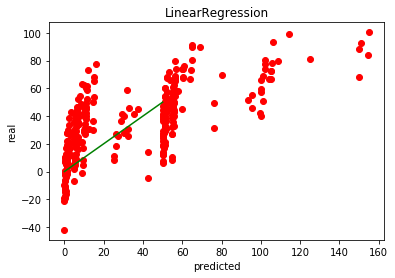

<module 'matplotlib.pyplot' from '/opt/projects/diss/jupyter_nbs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [21]:
# Create linear regression object
linreg = LinearRegression()

# Train the model using the training sets
linreg.fit(X_train,Y_train)

print ("Linear model: ", pretty_print_linear(linreg.coef_, names, sort = True))

# Predict the values using the model
Y_lin_predict = linreg.predict(X_test)

# Print the root mean square error 
print ("Root Mean Square Error: {}".format(root_mean_square_error(Y_lin_predict,Y_test)))
plot_real_vs_predicted(Y_test,Y_lin_predict, linreg)

In [22]:
generate_regression_values(linreg, X_test, Y_test)

    Coefficients  Standard Errors  t values  Probabilites
0       -49.8085              NaN       NaN           NaN
1         0.0000              NaN       NaN           NaN
2         4.0284              NaN       NaN           NaN
3        -0.0000              NaN       NaN           NaN
4         0.0000              NaN       NaN           NaN
5         0.0000              NaN       NaN           NaN
6         0.0000              NaN       NaN           NaN
7        -0.0000              NaN       NaN           NaN
8         0.0000              NaN       NaN           NaN
9        -0.7154              NaN       NaN           NaN
10        1.5405              NaN       NaN           NaN
11        0.0000              NaN       NaN           NaN
12        0.0000              NaN       NaN           NaN
13        0.0000              NaN       NaN           NaN
14        0.0000              NaN       NaN           NaN
15        0.0000              NaN       NaN           NaN
16        2.54

Lasso model:  5.269 * w_4_5 + 4.452 * w_3_4 + 3.994 * w_0_1 + 2.51 * w_2_3 + 1.505 * w_1_3 + -0.67 * w_1_2 + 0.0 * w_0_0 + 0.0 * w_0_2 + 0.0 * w_0_3 + 0.0 * w_0_4 + 0.0 * w_0_5 + 0.0 * w_1_0 + 0.0 * w_1_1 + 0.0 * w_1_4 + 0.0 * w_1_5 + 0.0 * w_2_0 + 0.0 * w_2_1 + 0.0 * w_2_2 + 0.0 * w_2_4 + 0.0 * w_2_5 + 0.0 * w_3_0 + 0.0 * w_3_1 + 0.0 * w_3_2 + 0.0 * w_3_3 + 0.0 * w_3_5 + 0.0 * w_4_0 + 0.0 * w_4_1 + 0.0 * w_4_2 + 0.0 * w_4_3 + 0.0 * w_4_4 + 0.0 * w_5_0 + 0.0 * w_5_1 + 0.0 * w_5_2 + 0.0 * w_5_3 + 0.0 * w_5_4 + 0.0 * w_5_5
Root Mean Square Error:  24.684721581383762


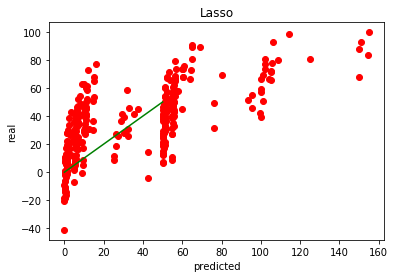

<module 'matplotlib.pyplot' from '/opt/projects/diss/jupyter_nbs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [23]:
X_train, X_test, Y_train, Y_test = split_data(X,Y)
# Create lasso regression object
lasso = Lasso(alpha=.3)

# Train the model using the training sets
lasso.fit(X_train, Y_train) 

print ("Lasso model: ", pretty_print_linear(lasso.coef_, names, sort = True))

# Predict the values using the model
Y_lasso_predict = lasso.predict(X_test)

# Print the root mean square error 
print ("Root Mean Square Error: ", root_mean_square_error(Y_lasso_predict,Y_test))
plot_real_vs_predicted(Y_test,Y_lasso_predict, lasso)

In [24]:
generate_regression_values(lasso, X_test, Y_test)

    Coefficients  Standard Errors  t values  Probabilites
0       -49.1773              NaN       NaN           NaN
1         0.0000              NaN       NaN           NaN
2         3.9939              NaN       NaN           NaN
3         0.0000              NaN       NaN           NaN
4         0.0000              NaN       NaN           NaN
5         0.0000              NaN       NaN           NaN
6         0.0000              NaN       NaN           NaN
7         0.0000              NaN       NaN           NaN
8         0.0000              NaN       NaN           NaN
9        -0.6699              NaN       NaN           NaN
10        1.5054              NaN       NaN           NaN
11        0.0000              NaN       NaN           NaN
12        0.0000              NaN       NaN           NaN
13        0.0000              NaN       NaN           NaN
14        0.0000              NaN       NaN           NaN
15        0.0000              NaN       NaN           NaN
16        2.51

In [25]:
# X_train, X_test, Y_train, Y_test = split_data(X,Y)

Elastic Net model:  5.199 * w_4_5 + 4.398 * w_3_4 + 3.94 * w_0_1 + 2.49 * w_2_3 + 1.5 * w_1_3 + -0.668 * w_1_2 + 0.0 * w_0_0 + 0.0 * w_0_2 + 0.0 * w_0_3 + 0.0 * w_0_4 + 0.0 * w_0_5 + 0.0 * w_1_0 + 0.0 * w_1_1 + 0.0 * w_1_4 + 0.0 * w_1_5 + 0.0 * w_2_0 + 0.0 * w_2_1 + 0.0 * w_2_2 + 0.0 * w_2_4 + 0.0 * w_2_5 + 0.0 * w_3_0 + 0.0 * w_3_1 + 0.0 * w_3_2 + 0.0 * w_3_3 + 0.0 * w_3_5 + 0.0 * w_4_0 + 0.0 * w_4_1 + 0.0 * w_4_2 + 0.0 * w_4_3 + 0.0 * w_4_4 + 0.0 * w_5_0 + 0.0 * w_5_1 + 0.0 * w_5_2 + 0.0 * w_5_3 + 0.0 * w_5_4 + 0.0 * w_5_5
Root Mean Square Error:  24.663672407428503


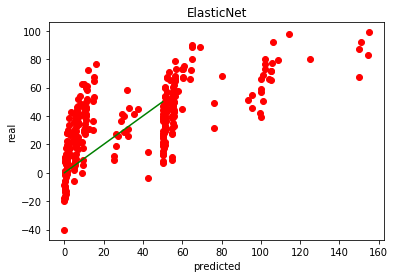

<module 'matplotlib.pyplot' from '/opt/projects/diss/jupyter_nbs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [26]:
elnet = ElasticNet(fit_intercept=True, alpha=.3)
              
# Train the model using the training sets
elnet.fit(X_train, Y_train) 

print ("Elastic Net model: ", pretty_print_linear(elnet.coef_, names, sort = True))

# Predict the values using the model
Y_elnet_predict = elnet.predict(X_test)

# Print the root mean square error 
print ("Root Mean Square Error: ", root_mean_square_error(Y_elnet_predict,Y_test))
plot_real_vs_predicted(Y_test,Y_elnet_predict, elnet)

In [27]:
generate_regression_values(elnet, X_test, Y_test)

    Coefficients  Standard Errors  t values  Probabilites
0       -48.1689              NaN       NaN           NaN
1         0.0000              NaN       NaN           NaN
2         3.9405              NaN       NaN           NaN
3         0.0000              NaN       NaN           NaN
4         0.0000              NaN       NaN           NaN
5         0.0000              NaN       NaN           NaN
6         0.0000              NaN       NaN           NaN
7         0.0000              NaN       NaN           NaN
8         0.0000              NaN       NaN           NaN
9        -0.6679              NaN       NaN           NaN
10        1.5003              NaN       NaN           NaN
11        0.0000              NaN       NaN           NaN
12        0.0000              NaN       NaN           NaN
13        0.0000              NaN       NaN           NaN
14        0.0000              NaN       NaN           NaN
15        0.0000              NaN       NaN           NaN
16        2.49

In [28]:
# X_train, X_test, Y_train, Y_test = split_data(X,Y)

Stochastic Gradient Descent model:  4.508 * w_4_5 + 3.988 * w_3_4 + 3.189 * w_0_1 + -1.779 * w_1_2 + 1.183 * w_2_3 + 0.132 * w_1_3 + 0.0 * w_0_0 + 0.0 * w_0_2 + 0.0 * w_0_3 + 0.0 * w_0_4 + 0.0 * w_0_5 + 0.0 * w_1_0 + 0.0 * w_1_1 + 0.0 * w_1_4 + 0.0 * w_1_5 + 0.0 * w_2_0 + 0.0 * w_2_1 + 0.0 * w_2_2 + 0.0 * w_2_4 + 0.0 * w_2_5 + 0.0 * w_3_0 + 0.0 * w_3_1 + 0.0 * w_3_2 + 0.0 * w_3_3 + 0.0 * w_3_5 + 0.0 * w_4_0 + 0.0 * w_4_1 + 0.0 * w_4_2 + 0.0 * w_4_3 + 0.0 * w_4_4 + 0.0 * w_5_0 + 0.0 * w_5_1 + 0.0 * w_5_2 + 0.0 * w_5_3 + 0.0 * w_5_4 + 0.0 * w_5_5
Root Mean Square Error:  26.832363406580047


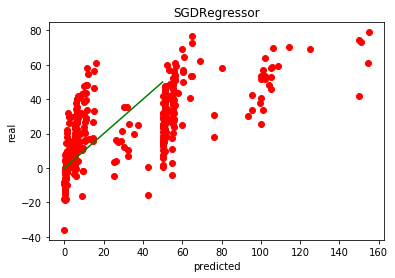

<module 'matplotlib.pyplot' from '/opt/projects/diss/jupyter_nbs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [29]:
sgdreg = SGDRegressor(penalty='l2', alpha=0.15)

# Train the model using the training sets
sgdreg.fit(X_train, Y_train) 

print ("Stochastic Gradient Descent model: ", pretty_print_linear(sgdreg.coef_, names, sort = True))

# Predict the values using the model
Y_sgdreg_predict = sgdreg.predict(X_test)

# Print the root mean square error 
print ("Root Mean Square Error: ", root_mean_square_error(Y_sgdreg_predict,Y_test))
plot_real_vs_predicted(Y_test,Y_sgdreg_predict, sgdreg)

#### Findings (Regression)
Didn't do well. Lets's try cluster.


### Label classifiers


In [30]:
from sklearn.cluster import KMeans
# X_train, X_test, Y_train, Y_test = split_data(X,Y)

In [31]:
X_train.describe()

,w_0_0,w_0_1,w_0_2,w_0_3,w_0_4,w_0_5,w_1_0,w_1_1,w_1_2,w_1_3,...,w_4_2,w_4_3,w_4_4,w_4_5,w_5_0,w_5_1,w_5_2,w_5_3,w_5_4,w_5_5
count,670.0,670.000000,670.0,670.0,670.0,670.0,670.0,670.0,670.000000,670.000000,...,670.0,670.0,670.0,670.000000,670.0,670.0,670.0,670.0,670.0,670.0
mean,0.0,4.885746,0.0,0.0,0.0,0.0,0.0,0.0,5.138597,5.103030,...,0.0,0.0,0.0,5.176209,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,2.887095,0.0,0.0,0.0,0.0,0.0,0.0,2.857651,2.853627,...,0.0,0.0,0.0,2.858577,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.010000,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.020000,...,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,2.500000,0.0,0.0,0.0,0.0,0.0,0.0,2.602500,2.650000,...,0.0,0.0,0.0,2.720000,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,4.760000,0.0,0.0,0.0,0.0,0.0,0.0,5.010000,5.260000,...,0.0,0.0,0.0,5.230000,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,7.377500,0.0,0.0,0.0,0.0,0.0,0.0,7.630000,7.517500,...,0.0,0.0,0.0,7.700000,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,9.990000,0.0,0.0,0.0,0.0,0.0,0.0,9.980000,10.000000,...,0.0,0.0,0.0,9.990000,0.0,0.0,0.0,0.0,0.0,0.0


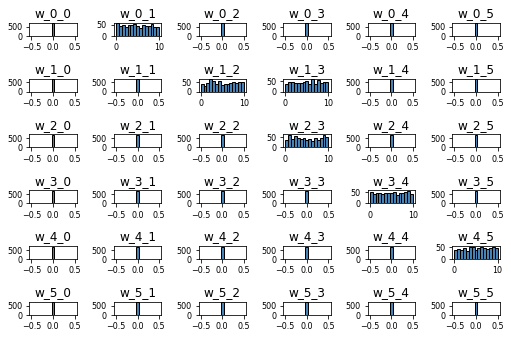

In [32]:
X_train.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   

In [33]:
 X_train, X_test, Y_train, Y_test = split_data(X,Y)
# Y_test.head()
# X_test.info()
X_train.isnull().values.any()
print(Y_train.dtypes, Y_test.dtypes) # expecting floats for these regressors
# Y_test = pd.to_numeric(Y_test)
print(Y_test)

float64 float64
521      6.130000
737     51.190000
740    104.333533
660     11.019612
411     93.500200
          ...    
506     50.020401
342     53.666667
485      0.218764
711    105.820717
133     52.166700
Name: score, Length: 330, dtype: float64


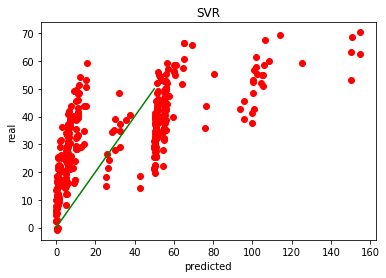

Root Mean Square Error:  24.9814372893341


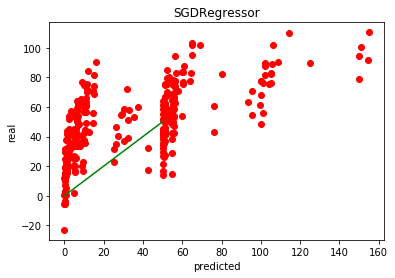

Root Mean Square Error:  29.51802495753085


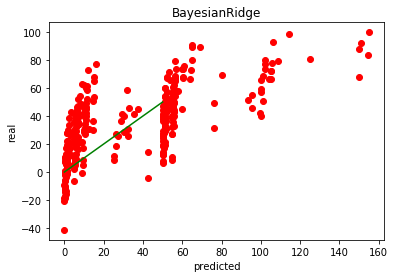

Root Mean Square Error:  24.683214089557815


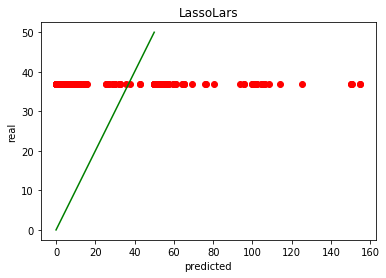

Root Mean Square Error:  33.3595956514295


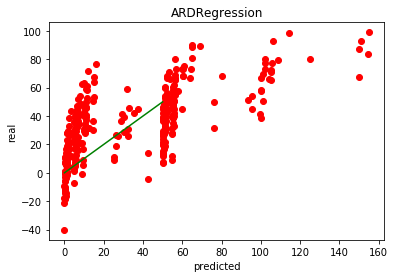

Root Mean Square Error:  24.68082363904802


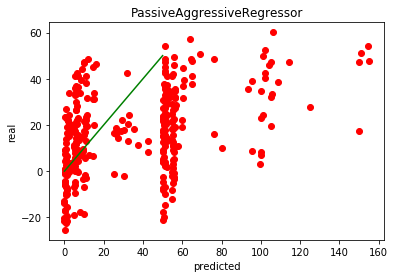

Root Mean Square Error:  35.253938679777576


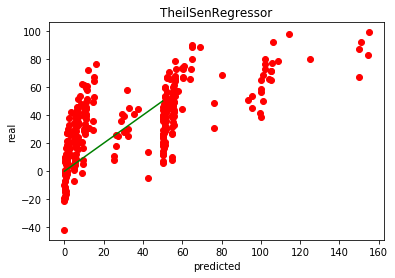

Root Mean Square Error:  24.669944473924723


In [34]:
from sklearn import svm
from sklearn import linear_model

classifiers = [
    svm.SVR(),
    linear_model.SGDRegressor(),
    linear_model.BayesianRidge(),
    linear_model.LassoLars(),
    linear_model.ARDRegression(),
    linear_model.PassiveAggressiveRegressor(),
    linear_model.TheilSenRegressor(),]

predictYs = []
for i, item in enumerate(classifiers):
    clf = item
    clf.fit(X_train, Y_train)
    Y_predict = clf.predict(X_test)  # https://github.com/scikit-learn/scikit-learn/pull/12867 ? 
#     print(Y_predict.size, Y_test.size, X_test.size)
    plot_real_vs_predicted(Y_test,Y_predict, item)
    print ("Root Mean Square Error: ", root_mean_square_error(Y_predict,Y_test))

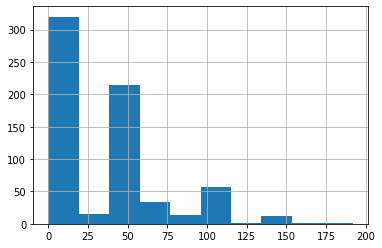

In [35]:
Y_train.hist()

### Encode Y labels (Metric Value)

(670,)


(array([65., 69., 66., 69., 64., 68., 65., 67., 67., 70.]),
 array([  0.,  63., 126., 189., 252., 315., 378., 441., 504., 567., 630.]),
 <a list of 10 Patch objects>)

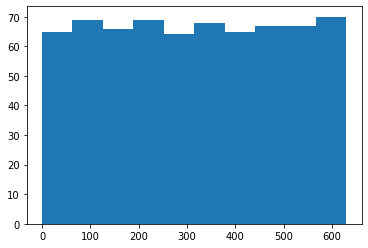

In [36]:
from sklearn import preprocessing
#creating labelEncoder
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
y_train_encoded=le.fit_transform(Y_train)
# print(y_train_encoded)
print(y_train_encoded.shape)

y_test_encoded=le.fit_transform(Y_test)
plt.hist(y_train_encoded)

DecisionTreeClassifier
{'criterion': 'gini', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': None, 'random_state': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'class_weight': None, 'presort': 'deprecated', 'ccp_alpha': 0.0}


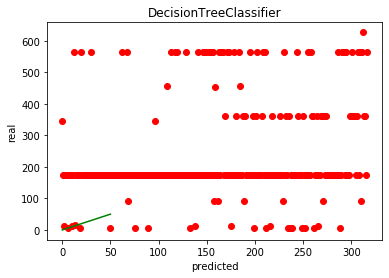

Root Mean Square Error:  246.36284976608718
RandomForestClassifier
{'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), 'n_estimators': 10, 'estimator_params': ('criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'min_weight_fraction_leaf', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'random_state', 'ccp_alpha'), 'bootstrap': True, 'oob_score': False, 'n_jobs': None, 'random_state': None, 'verbose': 0, 'warm_start': False, 'class_weight': None, 'max_samples': None, 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 

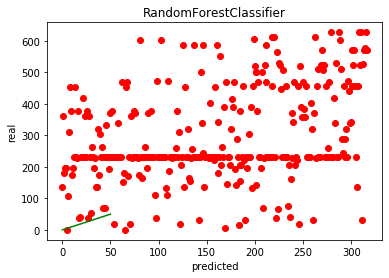

Root Mean Square Error:  294.7957912717237


In [37]:
from sklearn import svm
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model

# classifiers = [ # predict continuous values 
#     svm.SVR(),
#     linear_model.SGDRegressor(),
#     linear_model.BayesianRidge(),
#     linear_model.LassoLars(),
#     linear_model.ARDRegression(),
#     linear_model.PassiveAggressiveRegressor(),
#     linear_model.TheilSenRegressor(),]

classifiers = [  # predict discrete values (labels)
#     KNeighborsClassifier(3),
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#     MLPClassifier(alpha=1, max_iter=1000),
#     AdaBoostClassifier(),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis()
]

def plot_real_vs_predicted(y_pred,y_test, obj=None):
    plt.plot(y_pred,y_test,'ro')
    plt.plot([0,50],[0,50], 'g-')
    plt.xlabel('predicted')
    plt.ylabel('real')
    if obj:
        plt.title(obj.__class__.__name__)
    plt.show()
    return plt


predictYs = []
for i, item in enumerate(classifiers):
    print(item.__class__.__name__)
    print(item.__dict__)
    clf = item
    clf.fit(X_train, y_train_encoded)
    Y_predict = clf.predict(X_test)  # https://github.com/scikit-learn/scikit-learn/pull/12867 ? 
#     print(Y_predict.size, Y_test.size, X_test.size)
    plot_real_vs_predicted(y_test_encoded,Y_predict, item)
    print ("Root Mean Square Error: ", root_mean_square_error(Y_predict,Y_test))

(n=1) Root Mean Square Error: 314.33501892910715


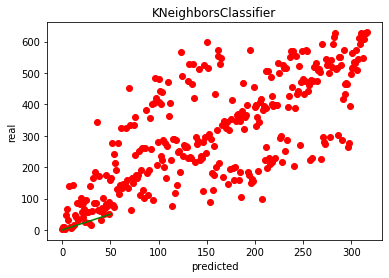

<module 'matplotlib.pyplot' from '/opt/projects/diss/jupyter_nbs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [38]:


# KNeighborsClassifier
# now try kmean clustering
knn = KNeighborsClassifier(n_neighbors=1)

# Train the model using the training sets
knn.fit(X_train,y_train_encoded)
# print(knn.__dict__)
# print ("Linear model: ", pretty_print_linear(knn.coef_, names, sort = True))

# Predict the values using the model
Y_knn_predict = knn.predict(X_test)

# Print the root mean square error 
print ("(n=1) Root Mean Square Error: {}".format(root_mean_square_error(Y_knn_predict,Y_test)))
plot_real_vs_predicted(y_test_encoded,Y_knn_predict, knn)

(n=5) Root Mean Square Error: 181.97657649111267


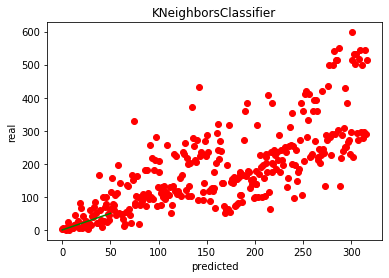

<module 'matplotlib.pyplot' from '/opt/projects/diss/jupyter_nbs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [39]:

# KNeighborsClassifier
# now try kmean clustering
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model using the training sets
knn.fit(X_train,y_train_encoded)
# print(knn.__dict__)
# print ("Linear model: ", pretty_print_linear(knn.coef_, names, sort = True))

# Predict the values using the model
Y_knn_predict = knn.predict(X_test)

# Print the root mean square error 
print ("(n=5) Root Mean Square Error: {}".format(root_mean_square_error(Y_knn_predict,Y_test)))
plot_real_vs_predicted(y_test_encoded,Y_knn_predict, knn)

(n=25) Root Mean Square Error: 155.1436658608156


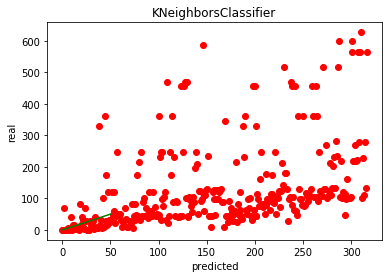

<module 'matplotlib.pyplot' from '/opt/projects/diss/jupyter_nbs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [40]:
# KNeighborsClassifier
# now try kmean clustering
knn = KNeighborsClassifier(n_neighbors=25)

# Train the model using the training sets
knn.fit(X_train,y_train_encoded)
# print(knn.__dict__)
# print ("Linear model: ", pretty_print_linear(knn.coef_, names, sort = True))

# Predict the values using the model
Y_knn_predict = knn.predict(X_test)

# Print the root mean square error 
print ("(n=25) Root Mean Square Error: {}".format(root_mean_square_error(Y_knn_predict,Y_test)))
plot_real_vs_predicted(y_test_encoded,Y_knn_predict, knn)

## Clustering


In [41]:
df_fnl.describe()
df_reduced = df_fnl.drop(columns='sample_uri')
cols_to_drop = df_reduced.columns[(df_reduced == 0).all()]
df_reduced = df_reduced.drop(columns=cols_to_drop )
df_reduced.describe()

,w_0_1,w_1_2,w_1_3,w_2_3,w_3_4,w_4_5,score
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.940850,5.121110,5.09931,5.012930,5.056450,5.032080,36.107870
std,2.875171,2.856995,2.85285,2.910674,2.913968,2.894216,35.488545
min,0.010000,0.010000,0.02000,0.020000,0.020000,0.000000,0.020600
25%,2.527500,2.607500,2.58000,2.467500,2.550000,2.580000,5.258434
50%,4.835000,5.115000,5.24000,4.975000,5.020000,5.015000,32.310100
75%,7.427500,7.592500,7.50250,7.685000,7.622500,7.630000,55.170250
max,9.990000,9.980000,10.00000,9.990000,9.990000,9.990000,191.833333


### Drop 0s columns.
Whats left is the transition matrices for each sample in the weighted rows, and the score labels this each sample

In [42]:
df_reduced.head()

,w_0_1,w_1_2,w_1_3,w_2_3,w_3_4,w_4_5,score
0,5.49,5.81,6.14,5.13,6.53,5.07,4.00
1,7.74,5.21,6.01,5.47,8.06,6.43,12.00
2,6.21,1.85,7.61,7.01,7.01,8.10,16.00
3,2.05,5.71,5.51,3.23,1.92,4.82,0.75
4,7.00,9.67,8.45,5.70,7.00,7.84,40.50


### Load new X, Y and training sets here

In [43]:
X = df_reduced.iloc[:,:-1]
Y = df_reduced.iloc[:,-1]
X_train, X_test, Y_train, Y_test = split_data(X,Y)

In [44]:
# df_reduced.iloc[0:]
df_reduced.iloc[:,0]
df_reduced.iloc[:,-1]

0        4.00000
1       12.00000
2       16.00000
3        0.75000
4       40.50000
         ...    
995    150.02012
996      0.05030
997      2.22012
998    105.01920
999     57.70010
Name: score, Length: 1000, dtype: float64

     w_0_1  w_1_2  w_1_3  w_2_3  w_3_4  w_4_5      score
0     5.49   5.81   6.14   5.13   6.53   5.07    4.00000
1     7.74   5.21   6.01   5.47   8.06   6.43   12.00000
2     6.21   1.85   7.61   7.01   7.01   8.10   16.00000
3     2.05   5.71   5.51   3.23   1.92   4.82    0.75000
4     7.00   9.67   8.45   5.70   7.00   7.84   40.50000
..     ...    ...    ...    ...    ...    ...        ...
995   8.75   2.09   7.80   1.56   8.94   9.08  150.02012
996   2.32   2.52   1.78   0.02   1.92   0.69    0.05030
997   3.44   2.56   7.56   0.84   5.35   6.30    2.22012
998   8.76   0.14   6.52   8.05   8.88   3.11  105.01920
999   7.75   7.52   6.70   1.19   9.55   3.85   57.70010

[1000 rows x 7 columns]
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


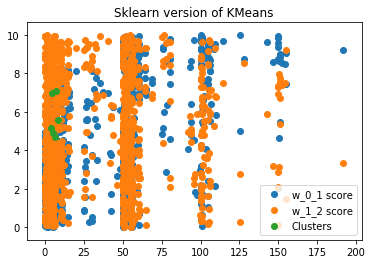

In [45]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=6)
clusters = km.fit(df_reduced)
print(df_reduced)
print(clusters)

plt.scatter(df_reduced.iloc[:,-1] ,df_reduced.iloc[:,0],  label='w_0_1 score')
plt.scatter(df_reduced.iloc[:,-1] ,df_reduced.iloc[:,1],  label='w_1_2 score')
# plt.scatter(df_reduced.iloc[:,-1] ,df_reduced.iloc[:,2],  label='Datapoints')
# plt.scatter(df_reduced.iloc[:,-1] ,df_reduced.iloc[:,3],  label='Datapoints')
# plt.scatter(df_reduced.iloc[:,-1] ,df_reduced.iloc[:,4],  label='Datapoints')
# plt.scatter(df_reduced.iloc[:,-1] ,df_reduced.iloc[:0,4],  label='Datapoints')
plt.scatter(clusters.cluster_centers_[:, 0], clusters.cluster_centers_[:, 1], label='Clusters')
plt.title("Sklearn version of KMeans")
plt.legend()
plt.show()



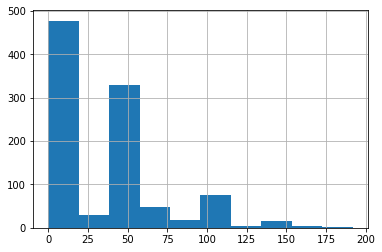

In [46]:
df_reduced["score"].hist()

## Embedding and random walks

Our clusters are weighted by euclidian distance, and our exp dist bunches everything towards the heavy side. We need a better way to measure the similarity between nodes in our transition graph. 

In [91]:
"""graph[ fontname = "Helvetica-Oblique",
            fontsize = 12,
            label = "some label",
            size = "7.75,10.25" ];"""
# Show an dot graph in this notebook
def plot_dot(ag, title=None):
    A = nx.nx_agraph.to_agraph(ag)
    if title:
        A.graph_attr.update(label=title, labelloc='top', labeljust='center', fontsize=24)
    # A.layout('dot', args='-Nfontsize=10 -Nwidth=".2" -Nheight=".2" -Nmargin=0 -Gfontsize=8')
    args = """
    -Gsize=5
    -Nfontname=Roboto
    -Efontname=Roboto
    -Nfontsize=8
    -Efontsize=8
    """
    A.layout('dot', args=args )
    # A.draw(self.outputDir + '/' + outfilename)
    A.draw()
    # plt.show()
    return graphviz.Source(A.to_string())



### DeepWalk

In [61]:
# https://github.com/prateekjoshi565/DeepWalk/blob/master/deepwalk_space.ipynb
import random
print(list(ag_reduced.neighbors('0')))
def get_randomwalk(node, path_length):
    random_walk = [node]
    for i in range(path_length-1):
        temp = list(ag_reduced.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break
        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node        
    return random_walk

get_randomwalk('0', 10)

['13']


['0', '13', '8', '5', '3', '1']

In [94]:
# Deepwalk looks a lot like our markov runner...
from tqdm import tqdm
from sklearn.decomposition import PCA
all_nodes = list(ag_reduced.nodes())
random_walks = []
for n in tqdm(all_nodes):
    for i in range(5):
        random_walks.append(get_randomwalk(n,10))

100%|██████████| 6/6 [00:00<00:00, 4429.04it/s]


### Word2Vec

In [93]:
# https://radimrehurek.com/gensim/index.html 
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')

# train word2vec model
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(random_walks, progress_per=2)

model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)


(160, 2000)

In [87]:
def plot_nodes(word_list, size=(12,9), title=None):
    X = model[word_list]
    
    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)    
    
    plt.figure(figsize=size)
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])
    plt.title(title)
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))        
    plt.show()

### DeepWalk and Word2Vec background here {citekey}

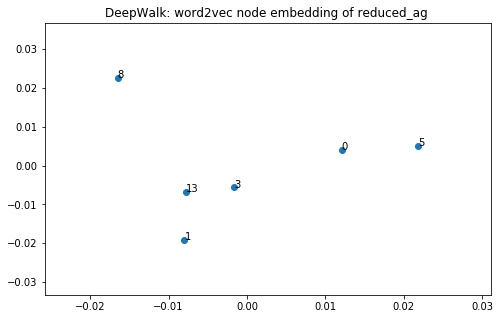

Word2Vec(vocab=6, size=100, alpha=0.03)
Find node similarity to (3):


[('0', 0.1788381040096283),
 ('3', 0.012232411652803421),
 ('13', -0.010226376354694366),
 ('1', -0.03246862813830376),
 ('8', -0.0985027551651001)]

In [90]:
terms= ag_reduced.nodes
plot_nodes(terms, size=(8,5), title="DeepWalk: word2vec node embedding of reduced_ag ")


print(model)
# find top n similar nodes
print('Find node similarity to (3):')
model.similar_by_word('5')

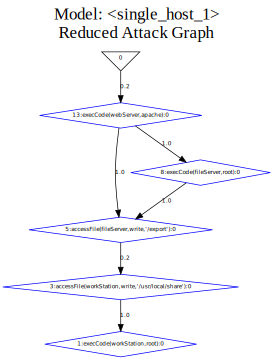

In [92]:

import IPython.display
display(plot_dot(ag_reduced, "Model: <{}>\nReduced Attack Graph".format(ag_reduced.name)))

### StellarGraph loading (more impls)

In [96]:
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.0.0rc2")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.0.0rc2, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

from stellargraph import StellarGraph

In [99]:
def compute_features(g):
    """Manually add features vectors to a nx graph"""
    for node in g.nodes().keys():
#         print(g.nodes[node].keys())
        if 'mttf'in g.nodes[node].keys():
            g.nodes[node]["feature"] = [float(g.nodes[node]['mttf'])]
    for u,v,k,e in g.edges(keys=True, data=True):
#         print(e.keys())
        e["feature"] = [float(e['weight']),float(e['score']), float(e['score_orig'])]





In [101]:
 
sg_ag = StellarGraph.from_n etworkx(ag, node_type_attr="type")
# print(sg_ag.info())

compute_features(ag_reduced) # add feature vectors to graph before sg load
# print(ag_reduced.to_dots())
sg_ag_reduced = StellarGraph.from_networkx(ag_reduced, node_type_attr="type", node_features="feature")
print(sg_ag_reduced.info())


StellarDiGraph: Directed multigraph
 Nodes: 6, Edges: 6

 Node types:
  OR: [5]
    Features: float32 vector, length 1
    Edge types: OR-0.2->OR, OR-1.0->OR
  attacker_origin: [1]
    Features: float32 vector, length 1
    Edge types: attacker_origin-0.2->OR

 Edge types:
    OR-1.0->OR: [4]
        Weights: all 1 (default)
    attacker_origin-0.2->OR: [1]
        Weights: all 0.2
    OR-0.2->OR: [1]
        Weights: all 0.2


In [102]:

sg_fg = StellarGraph.from_networkx(fg, node_type_attr="type")
print(sg_fg.info())

StellarDiGraph: Directed multigraph
 Nodes: 4, Edges: 13

 Node types:
  HOST: [4]
    Features: none
    Edge types: HOST-default->HOST

 Edge types:
    HOST-default->HOST: [13]
        Weights: all 1 (default)


In [112]:
print(fg.nodes(data=True))

[('webServer', {'color': 'blue', 's': 's', 'shape': 'box', 'type': 'HOST'}), ('fileServer', {'color': 'blue', 's': 's', 'shape': 'box', 'type': 'HOST'}), ('internet', {'color': 'blue', 's': 's', 'shape': 'box', 'type': 'HOST'}), ('workStation', {'color': 'blue', 's': 's', 'shape': 'box', 'type': 'HOST'})]


## Conclusion